# Load the transformed data 

In [1]:
# Load necessary libraries for the Data Exploration 
import pandas as pd
import os
import numpy as np

In [2]:
os.getcwd()#get your working directory (optional)

'/Users/spiliostzouras/Downloads'

In [3]:
# Set the right directory to read the data from
#%cd /Users/spiliostzouras/Documents/Udacity_DS_Nanodegree
%cd ~/Library/Mobile\ Documents/com~apple~CloudDocs/Documents/Udacity_DS_Nanodegree/

/Users/spiliostzouras/Library/Mobile Documents/com~apple~CloudDocs/Documents/Udacity_DS_Nanodegree


In [4]:
# Check the files in the directory optional
os.listdir()

['reviews.csv',
 'merged_data.csv',
 'listings.csv',
 'reviews_no_missing.csv',
 'calendar.csv',
 'map1.png']

In [5]:
# Read / load the files 
reviews_new = pd.read_csv("reviews_no_missing.csv")
merged_data = pd.read_csv("merged_data.csv")

/Users/spiliostzouras/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Check quickly the size of teh dataset to ensure it is correct
merged_data.shape

(1393570, 71)

In [7]:
# We can exclude the records of the dates that the property is not available, so only available 
merged_data_avl = merged_data.copy()
merged_data_avl = merged_data_avl.loc[merged_data_avl['available']== 't']

In [8]:
# Check the size of the new dataset
merged_data_avl.shape

(934542, 71)

# Question 1: Would it be possible to cluster the properties by geographic location, how many clusters exist and wh are their centers


The question above could be of interest to companies that want to do business by serving the tenants of the properties listed on AirBnB. Assuming that these tenants are present in the area only for a short period of time, the types of business could range from restaurants to mini markets...etc. To optimize business a player would need to know i) how many new shops / branches to open and ii) at which location.
To answer the question above we will perform K-means clustering. This will eventually provide the "optimal" number of clusters and their centroids. The process consists of teh following steps: 
- Employ the elbow method to identify the "optimal" number of clusters
- Define the number of clusters 
- Perform K-means clustering, given the number of cluster decided in the previous step

In [9]:
# import essential files for K-means
import pandas as pd # for data manipulation
import time # for adding time delays
from sklearn.cluster import KMeans # for k-means clustering
import plotly
import matplotlib.pyplot as plt # for data visualization
from plotly import graph_objs as go # for data visualization

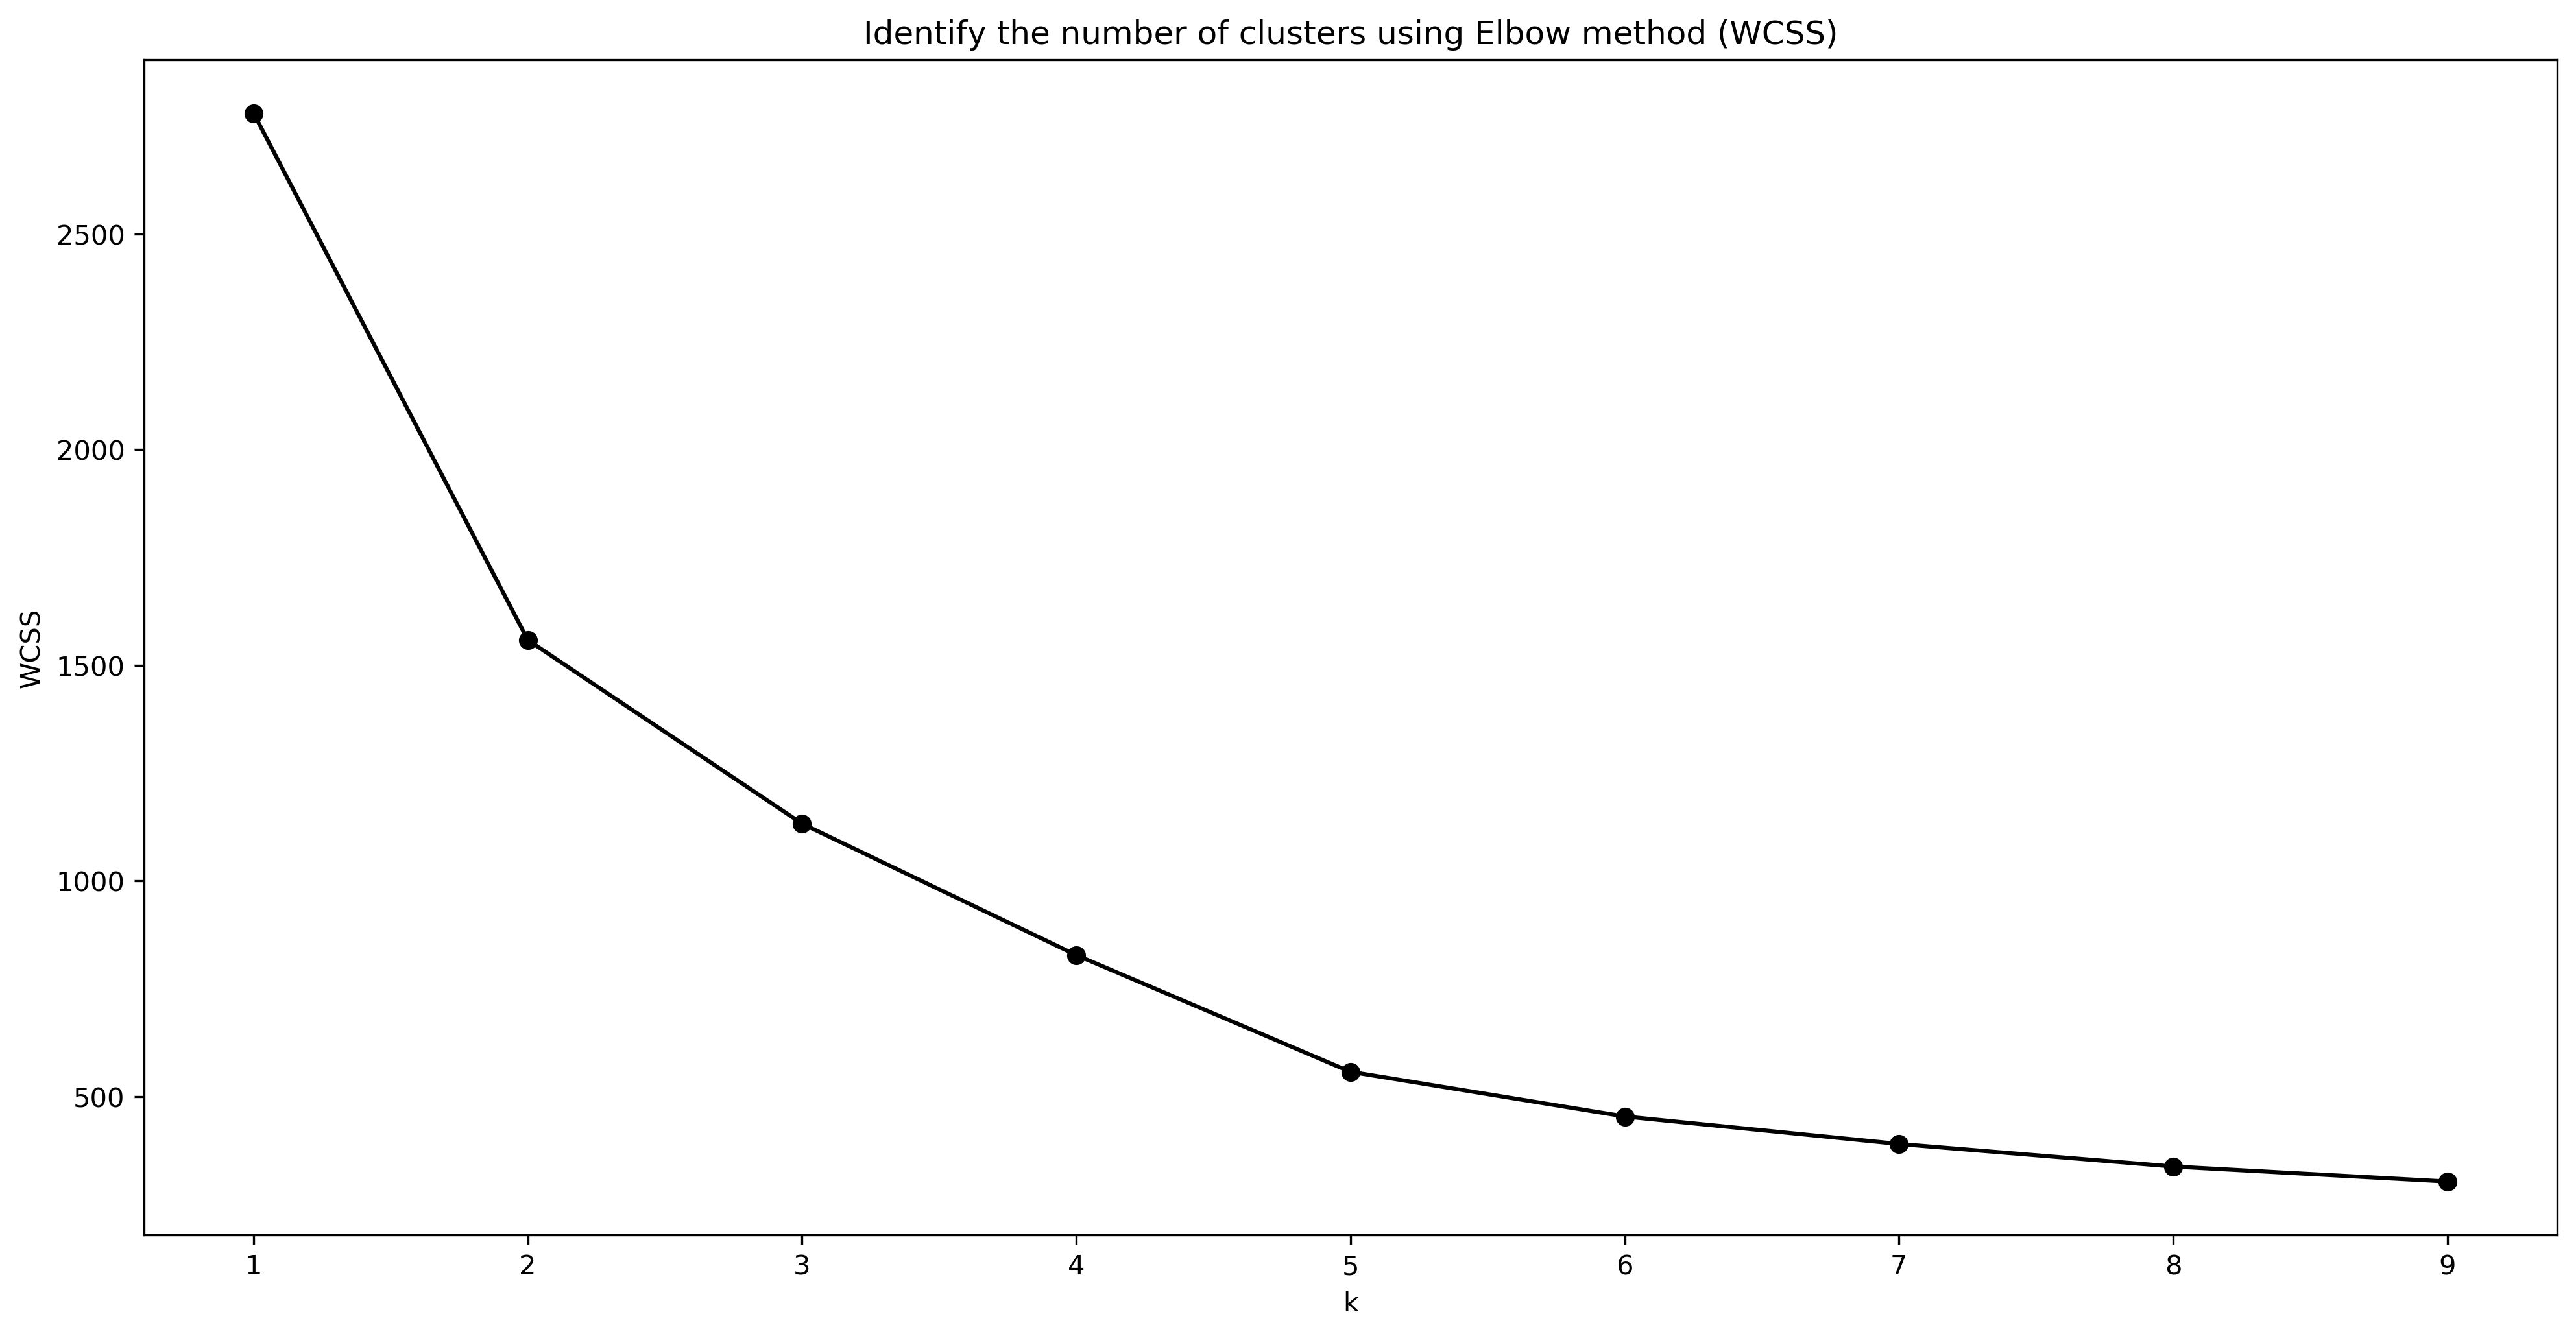

In [10]:
# Identify the optimal number of clusters using Elbow method (WCSS)
WCSS = []
K=range(1,10)
for k in K:
    kmod = KMeans(n_clusters=k)
    kmod.fit(merged_data_avl[['latitude', 'longitude']])
    WCSS.append(kmod.inertia_)
    
# Plot elbow graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, WCSS, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Identify the number of clusters using Elbow method (WCSS)')
plt.show()

From the plot above it can be deducted that 5 clusters are enough to explain the variablity across coordinates and further partitioning would be 

In [11]:
# Select data for clustering model
X = merged_data_avl[['latitude', 'longitude']]

# Set the model and its parameters - 3 clusters
cluster_model = KMeans(n_clusters=5,
                init='k-means++', # Smart initialization of centroids, alternative option 'random'
                n_init=10, # Number of time the k-means algorithm will be run with different centroid seeds, default=10
                max_iter=100, # maximum number of iterations to run default=300
               )

In [12]:
clust = cluster_model.fit(X)

In [13]:
# Print model summary
print('*************** Cluster Model ***************')
print('Cluster centers: ', clust.cluster_centers_)
print('Inertia (WCSS): ', clust.inertia_)
print('No. of iterations: ', clust.n_iter_)
print()


*************** Cluster Model ***************
Cluster centers:  [[  47.5601787  -122.28919722]
 [  47.66614874 -122.36618461]
 [  47.55699303 -122.38216953]
 [  47.67960591 -122.31180905]
 [  47.61770029 -122.32386951]]
Inertia (WCSS):  557.5262360588116
No. of iterations:  14



In [14]:
# Attach cluster labels to the original dataset
data=merged_data_avl.copy()
data['Clust']=list(clust.labels_)

In [15]:
BBox = ((data.longitude.min(),   data.longitude.max(), data.latitude.min(), data.latitude.max()))
print(BBox)

(-122.41721881425622, -122.24060703053992, 47.50508834369015, 47.73335790856483)


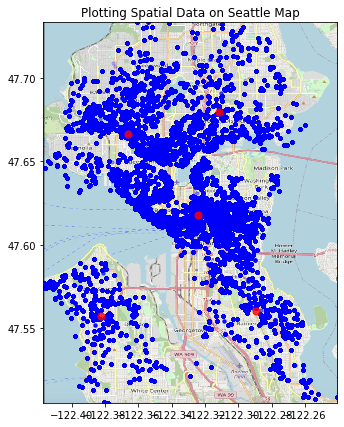

In [16]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(data.longitude, data.latitude, zorder=1, alpha= 0.2, c='b', s=10)
lat = [clust.cluster_centers_[i-1][0]  for i in range(0,len(clust.cluster_centers_))]
long = [clust.cluster_centers_[i-1][1]  for i in range(0,len(clust.cluster_centers_))]
ax.scatter(long, lat, zorder=4, alpha= 0.8, c='r', s=50)
ruh_m = plt.imread('map1.png') # read a picture already stored locally 
ax.set_title('Plotting Spatial Data on Seattle Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
#ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')


In [17]:
data.price_x=data.price_x.replace('[\$,]', '', regex=True).astype(float)

In [18]:
data.groupby('Clust')['price_x'].mean()

Clust
0     97.674917
1    132.427931
2    124.330192
3    105.718961
4    139.379444
Name: price_x, dtype: float64

# Question 2: Would it be possible to identify the main drivers of property rental rates?


The question above could be of interest to both property owners and individuals looking for accommodation. It is assumed that the former would be interested in knowing what affects the price of an apartment so they can adjust their rates accordingly and the latter would benefit from knowing the significant factors that determine rental prices so they can adjust their searching criteria accordingly. 
To answer the question above we will built a decision tree and let the structure of the tree (variables and their thresholds) reveal the what drives each property into the cluster. Decision trees are in general prone to overfitting and random forests (collection of trees) are more robust methods, but for the purpose of this exercise a single tree is sufficient, since we are not interested in making accurate predictions 
- Apply one hot encoding on categorical variables of interest 
- Set the target variable 
- Run a desicion tree and observe that average prices in terminal nodes

In [19]:
# Load necessary libraries 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn import tree

In [20]:
# Select categorical data in scope
categorical_cols = ['property_type', 'room_type'] 

# Apply one hot encoding method on the selected categorical variables
data_ohe = pd.get_dummies(data, columns = categorical_cols)

In [21]:
#define the indpendent / explanatory variables in scope
feature_cols = ['property_type_Apartment',
       'property_type_Bed & Breakfast', 'property_type_Boat',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Dorm',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Tent', 'property_type_Townhouse',
       'property_type_Treehouse', 'property_type_Yurt',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room' ,'accommodates', 'bathrooms', 'bedrooms','minimum_nights']
X = data_ohe[feature_cols] #select the indpendent / explanatory variables in scope
y = data_ohe.price_x # Target variable

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


In [23]:
# Create Decision Tree rlegressor object
dtr = DecisionTreeRegressor (max_depth=3, random_state=1234)

# Train Decision Tree Regressor
model = dtr.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [24]:
text_representation = tree.export_text(dtr)
print(text_representation)

|--- feature_21 <= 1.65
|   |--- feature_16 <= 0.50
|   |   |--- feature_18 <= 0.50
|   |   |   |--- value: [77.17]
|   |   |--- feature_18 >  0.50
|   |   |   |--- value: [47.60]
|   |--- feature_16 >  0.50
|   |   |--- feature_21 <= 0.50
|   |   |   |--- value: [103.96]
|   |   |--- feature_21 >  0.50
|   |   |   |--- value: [122.88]
|--- feature_21 >  1.65
|   |--- feature_20 <= 2.25
|   |   |--- feature_20 <= 1.38
|   |   |   |--- value: [159.69]
|   |   |--- feature_20 >  1.38
|   |   |   |--- value: [217.47]
|   |--- feature_20 >  2.25
|   |   |--- feature_21 <= 4.50
|   |   |   |--- value: [303.60]
|   |   |--- feature_21 >  4.50
|   |   |   |--- value: [464.78]



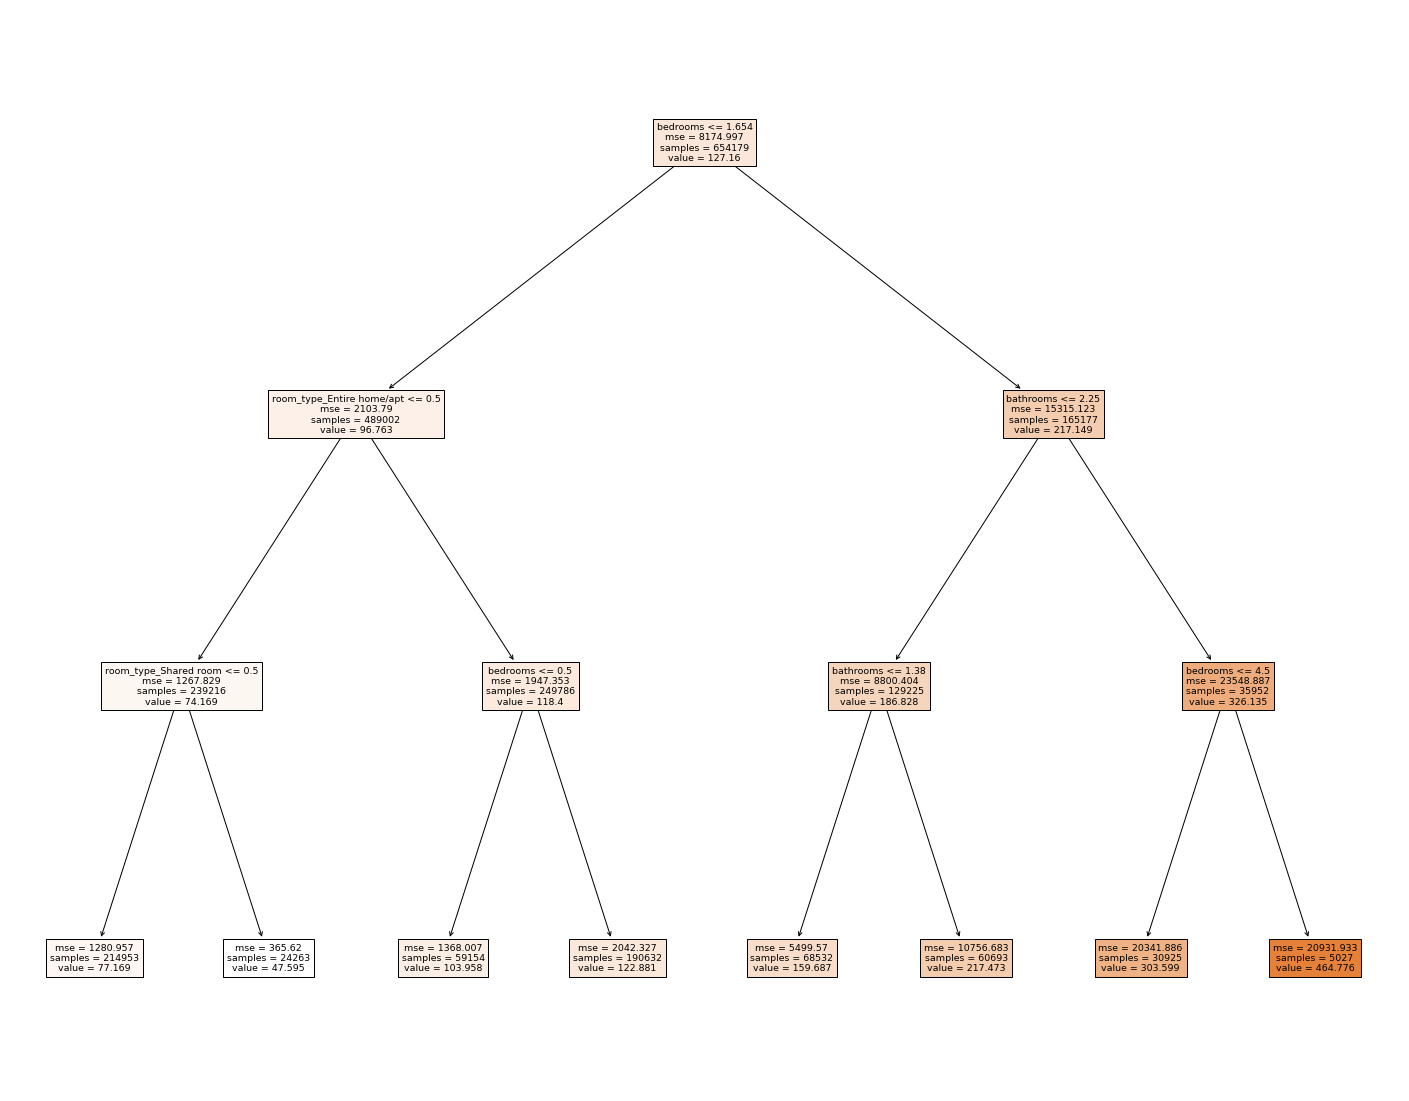

In [25]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtr, feature_names=feature_cols, filled=True)

As expected the higher the number of bedrooms and bathrooms the higher the rent. The non-linear capabilities of a decision tree model allows it to provide specific cut-offs, that resulting in spliting the appartments to different groups with respect to price level.

It is worth mentioning however that appaertments with up to 1.5 bedrooms that are to be shared have the lowest rent. 

# Question 3: What is the distribution of the rental prices and how much does the price distribution differ among clusters 

The question above could be of interest to both investors in the real estate business and potential tenants for that it provides information about the market in each cluster, for example what is the min, max and average price...etc
- Obtain the histogram and summary statistics of the price for the entire dataset 
- Obtain the histogram and summary statistics of the price for each cluster

### Entire dataset

In [26]:
# Display the summary stats of the entire dataset
data['price']=data.price_x.replace('[\$,]', '', regex=True).astype(float)# convert the price from text to numeric
data.price.describe()

count    934542.000000
mean        127.249518
std          90.602147
min          20.000000
25%          75.000000
50%         100.000000
75%         150.000000
max        1000.000000
Name: price, dtype: float64

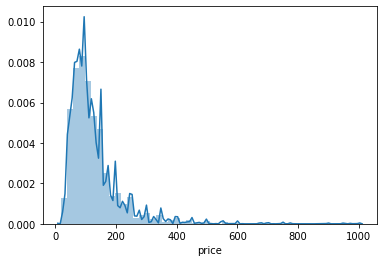

In [27]:
# Plot the histogram of prices for the entire dataset
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(data['price'])

### First cluster, coordinates: [  47.67967409 -122.31176276]

count    86335.000000
mean        97.674917
std         62.569098
min         25.000000
25%         60.000000
50%         80.000000
75%        108.000000
max        399.000000
Name: price, dtype: float64


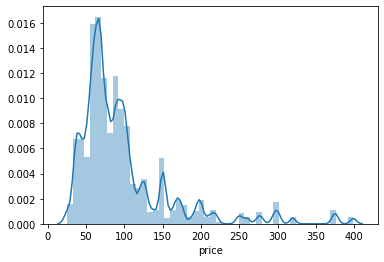

In [28]:
# Plot the histogram of prices for the cluster with coordinates: [  47.67967409 -122.31176276]
print(data[data['Clust']==0]['price'].describe())
sns.distplot(data[data['Clust']==0]['price'])


### Second cluster, coordinates: [  47.5601787  -122.28919722]

count    219187.000000
mean        132.427931
std         101.357023
min          20.000000
25%          75.000000
50%          99.000000
75%         150.000000
max         975.000000
Name: price, dtype: float64


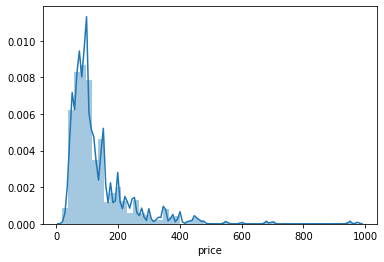

In [29]:
# Plot the histogram of prices for the cluster with coordinates:  [  47.5601787  -122.28919722]
print(data[data['Clust']==1]['price'].describe())
sns.distplot(data[data['Clust']==1]['price'])

### Third cluster, coordinates: [  47.66614874 -122.36618461]

count    73854.000000
mean       124.330192
std         84.330025
min         30.000000
25%         70.000000
50%         95.000000
75%        148.000000
max        495.000000
Name: price, dtype: float64


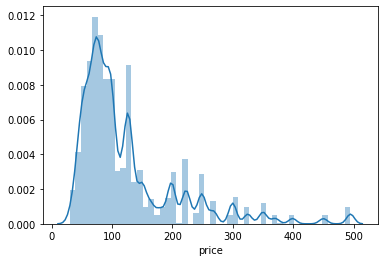

In [30]:
# Plot the histogram of prices for the cluster with coordinates:  [  47.66614874 -122.36618461]
print(data[data['Clust']==2]['price'].describe())
sns.distplot(data[data['Clust']==2]['price'])

### Forth cluster, coordinates:  [  47.61773057 -122.32387597]

count    151520.000000
mean        105.718961
std          79.021884
min          26.000000
25%          62.000000
50%          89.000000
75%         120.000000
max        1000.000000
Name: price, dtype: float64


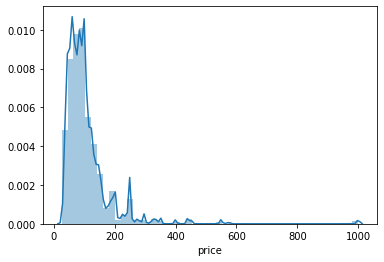

In [31]:
# Plot the histogram of prices for the cluster with coordinates:   [  47.61773057 -122.32387597]
print(data[data['Clust']==3]['price'].describe())
sns.distplot(data[data['Clust']==3]['price'])

### Fifth cluster, coordinates:   [  47.55699303 -122.38216953]]


count    403646.000000
mean        139.379444
std          91.760120
min          22.000000
25%          85.000000
50%         120.000000
75%         160.000000
max         899.000000
Name: price, dtype: float64


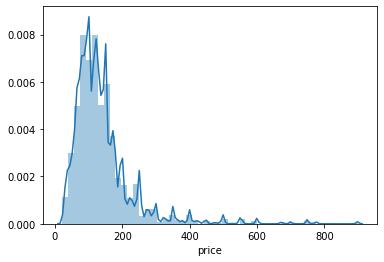

In [33]:
# Plot the histogram of prices for the cluster with coordinates:   [  47.55699303 -122.38216953]]]
print(data[data['Clust']==4]['price'].describe())
sns.distplot(data[data['Clust']==4]['price'])